In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP

# 条件数の増加に対する疎信号再構成の性能比較

In [3]:
N = 500  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [4]:
SNR = 60  # 信号対雑音比
P = 50  # ノード数
T = 30  # 反復回数
sim = int(1e+6)  # 範囲
realization = 100  # 実験数
cond_num = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]  # 実験を行う回

In [5]:
MSE_oamp = np.zeros((2, realization, sim))
MSE_doamp = np.zeros((2, realization, sim))

In [6]:
l = len(cond_num)
CommCost_doamp = np.empty((2, l, realization, T))

In [7]:
for i in tqdm(range(realization)):
    x = bernouli_gaussian(N, rho)
    UniInv = UniInvar(M, N, 1)
    count = 0

    for j in range(sim):
        kappa = j+1
        if kappa not in cond_num: continue

        UniInv.change_cond(kappa)
        oamp = [OAMP(UniInv.A, x, SNR) for _ in range(2)]
        doamp = [D_OAMP(UniInv.A, x, SNR, P) for _ in range(2)]

        oamp[0].estimate(T=T, ord='PINV')
        oamp[1].estimate(T=T, ord='LMMSE')
        doamp[0].estimate(T=T, ord='PINV')
        doamp[1].estimate(T=T, ord='LMMSE')

        for k in range(2):
            MSE_oamp[k, i, j] = oamp[k].mse[-1]
            MSE_doamp[k, i, j] = doamp[k].mse[-1]
            
            CommCost_doamp[k, count, i] = doamp[k].communication_cost
        count += 1

100%|██████████| 10/10 [42:33<00:00, 255.33s/it]


In [8]:
MSE_oamp_mean = np.empty((2, sim))
MSE_doamp_mean = np.empty((2, sim))

In [9]:
for i in range(2):
    MSE_oamp_mean[i] = np.mean(MSE_oamp[i], axis=0)
    MSE_doamp_mean[i] = np.mean(MSE_doamp[i], axis=0)
    
    for j in range(sim):
        if MSE_oamp_mean[i, j] == 0:
            MSE_oamp_mean[i, j] = None
        if MSE_doamp_mean[i, j] == 0:
            MSE_doamp_mean[i, j] = None

In [10]:
CommCost_doamp_mean = np.empty((2, l, T))

In [11]:
for i in range(2):
    for j in range(l):
        CommCost_doamp_mean[i, j] = np.mean(CommCost_doamp[i, j], axis=0)

# MSE

## OAMPの場合

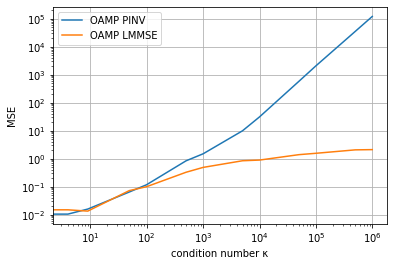

In [12]:
plt_MSE_cond(MSE_oamp_mean[0], 'OAMP PINV', sim)
plt_MSE_cond(MSE_oamp_mean[1], 'OAMP LMMSE', sim)
plt.grid()

## D-OAMPの場合

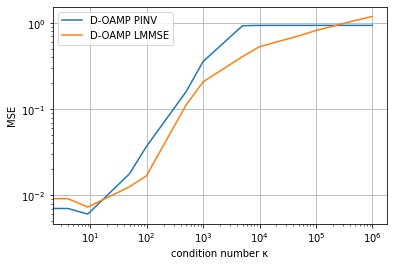

In [13]:
plt_MSE_cond(MSE_doamp_mean[0], 'D-OAMP PINV', sim)
plt_MSE_cond(MSE_doamp_mean[1], 'D-OAMP LMMSE', sim)
plt.grid()

## すべて

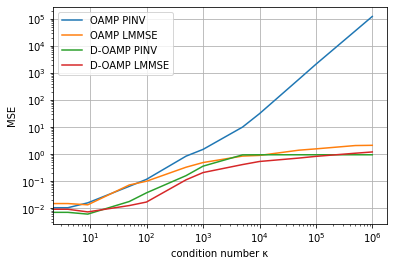

In [14]:
plt_MSE_cond(MSE_oamp_mean[0], 'OAMP PINV', sim)
plt_MSE_cond(MSE_oamp_mean[1], 'OAMP LMMSE', sim)
plt_MSE_cond(MSE_doamp_mean[0], 'D-OAMP PINV', sim)
plt_MSE_cond(MSE_doamp_mean[1], 'D-OAMP LMMSE', sim)
plt.grid()

# 通信量

In [15]:
def plt_CC_cond(n):
    plt.title('κ = '+str(cond_num[n]))
    plt_CC(CommCost_doamp_mean[0, n], 'D-OAMP PINV', T, N, P)
    plt_CC(CommCost_doamp_mean[1, n], 'D-OAMP LMMSE', T, N, P)
    plt.grid()

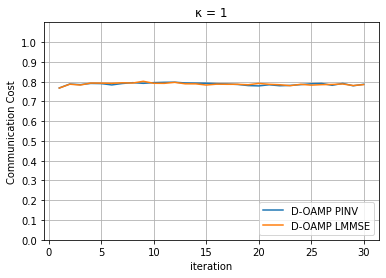

In [16]:
plt_CC_cond(0)

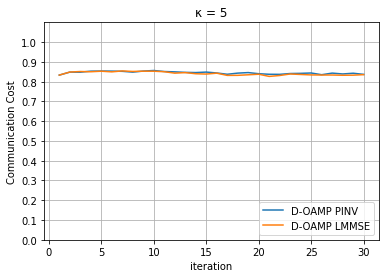

In [17]:
plt_CC_cond(1)

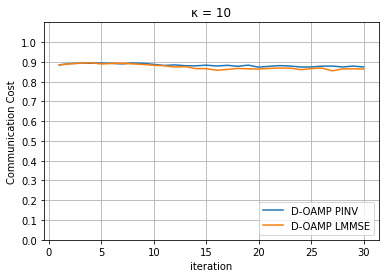

In [18]:
plt_CC_cond(2)

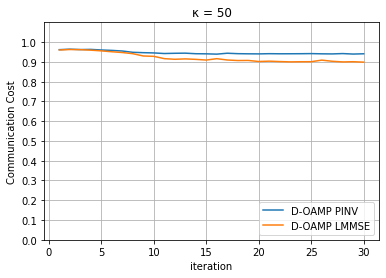

In [19]:
plt_CC_cond(3)

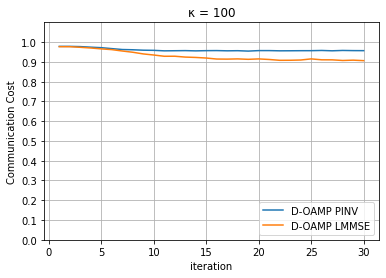

In [20]:
plt_CC_cond(4)

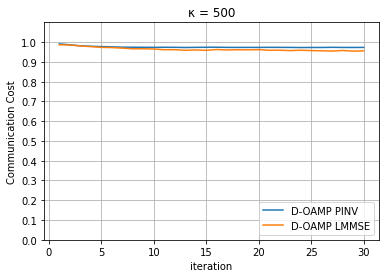

In [21]:
plt_CC_cond(5)

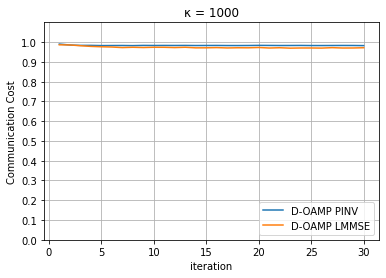

In [22]:
plt_CC_cond(6)

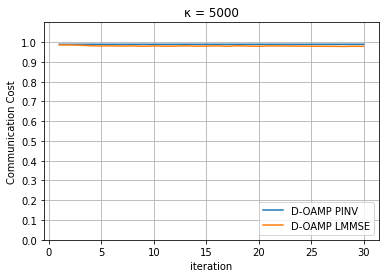

In [23]:
plt_CC_cond(7)

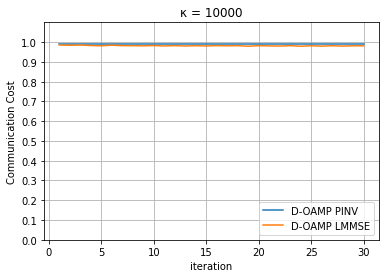

In [24]:
plt_CC_cond(8)

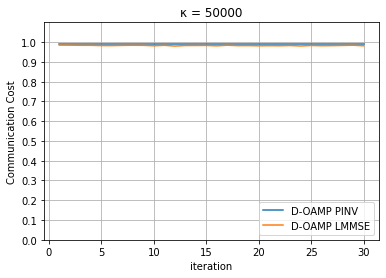

In [25]:
plt_CC_cond(9)

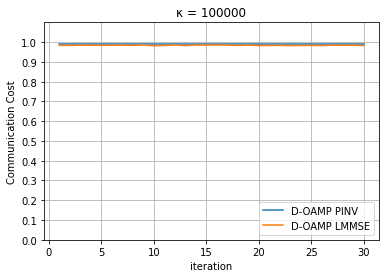

In [26]:
plt_CC_cond(10)

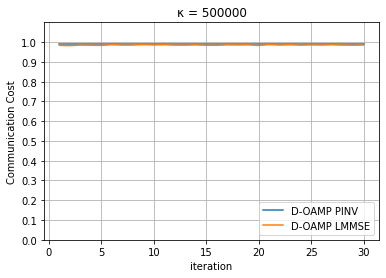

In [27]:
plt_CC_cond(11)

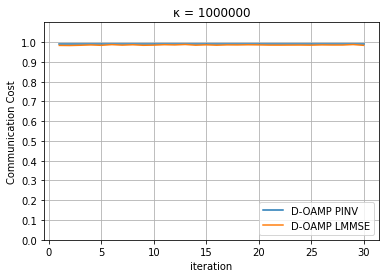

In [28]:
plt_CC_cond(12)

final mse: 115051.40843643836


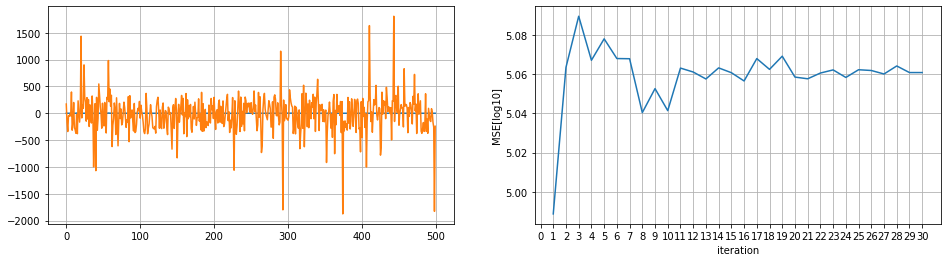

In [29]:
oamp[0].result()

final mse: 1.2721551825930835


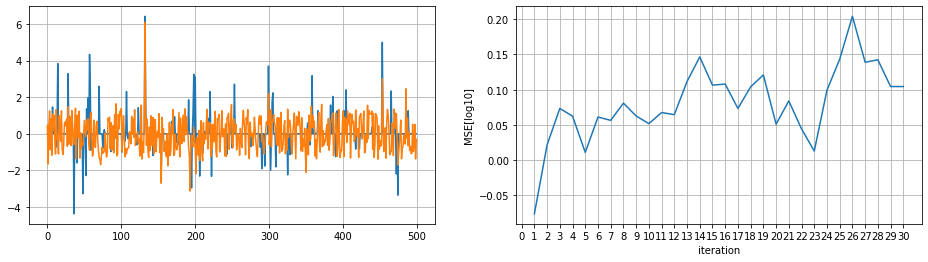

In [30]:
oamp[1].result()

final mse: 0.7056871685141606


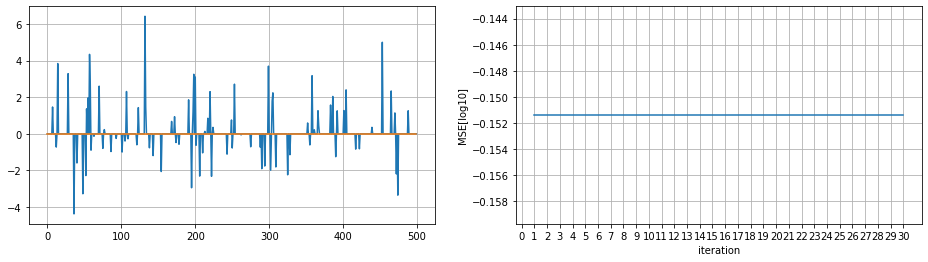

In [31]:
doamp[0].result()

final mse: 0.7115758422726286


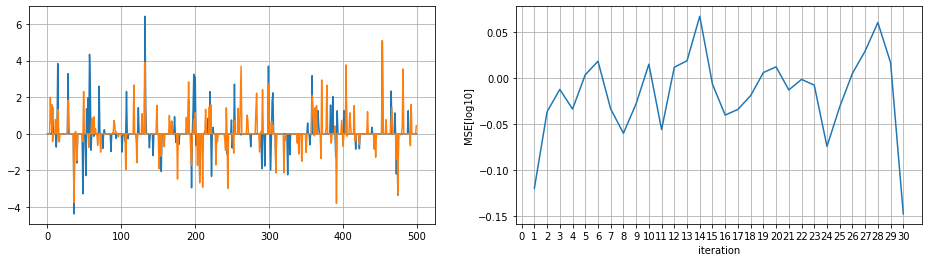

In [32]:
doamp[1].result()